In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)
from scipy.stats import mode
from scipy import stats
import feather
import re
import warnings
import random

from IPython.display import clear_output

In [2]:
target = pd.read_csv('target2',header=None,index_col=0)

In [142]:
################ everything ################ CV score: 3.69761
train = feather.read_dataframe('train')
test = feather.read_dataframe('test')
########################################

In [141]:
############################ all merchant cats ############################
train = feather.read_dataframe('merchants_and_city_id\\all_done_train')
test = feather.read_dataframe('merchants_and_city_id\\all_done_top_test')
########################################################################

In [165]:
################ after all test table ################ CV score: 3.68155 
train = feather.read_dataframe('ensemble\\top_train')
test = feather.read_dataframe('ensemble\\top_test')
#################################################### 3.68088 with merch and city

In [86]:
merch_and_city = feather.read_dataframe('merchants_and_city_id\\groupped')

In [87]:
merch_mode_cols = ['state_id_min','state_id_max','state_id_add_mode','subsector_id_min','subsector_id_max','subsector_id_add_mode']

In [88]:
train = pd.merge(train,merch_and_city,on='card_id',how='left')
test = pd.merge(test,merch_and_city,on='card_id',how='left')

In [89]:
train = pd.merge(train,train2,on='card_id',how='left')
test = pd.merge(test,test2,on='card_id',how='left')

In [92]:
features = [c for c in train.columns if c not in ['card_id', 'first_active_month','last_active_month']]
categorical_feats = [x for x in train.columns.values if (re.search('modeplus',x) or re.search('feature_',x))] + merch_mode_cols

In [110]:
features67 = features

In [166]:
features = [c for c in train if c not in ['card_id', 'first_active_month','last_active_month']]
#features = [c for c in columns_rating.index[30:] if c not in ['card_id', 'first_active_month','last_active_month']]
categorical_feats = [x for x in features if (re.search('modeplus',x) or re.search('feature_',x))] + [x for x in merch_mode_cols if x in features]

In [167]:
warnings.filterwarnings("ignore")
outputs = []
ptest = 1
for ptest in range(1):
    param = {
            'num_leaves': 111, #checked
             'num_threads': 4,
             'max_bin': 150, #checked
             'min_data_in_leaf': 100, #checked
             'objective':'regression',
             'max_depth': 9, #checked
             'tree_learner':'data',
             'learning_rate': 0.07,
             "boosting": "gbdt", #dart, gbdt
             "feature_fraction": 0.75, #checked
             "bagging_freq": 5, #5
             "bagging_fraction": 0.75, #checked
             "bagging_seed": 11,
             "metric": 'rmse',
             "lambda_l1": 0.26, #checked
#            'lambda_l2': 0.3, #checked
             "random_state": 77,
             "verbosity": -1,
             "device":"gpu",
             'gpu_device_id':0,
             'gpu_platform_id':1,
             'gpu_use_dp':True,
            }

    
    folds = KFold(n_splits=5, shuffle=True, random_state=15)
    oof = np.zeros(len(train))
    predictions = np.zeros(len(test))
    start = time.time()
    feature_importance_df = pd.DataFrame()

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
        print("fold n°{}".format(fold_))
        
        trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                               label=target.iloc[trn_idx],
                               categorical_feature=categorical_feats
                              )
        val_data = lgb.Dataset(train.iloc[val_idx][features],
                               label=target.iloc[val_idx],
                               categorical_feature=categorical_feats
                              )


        clf = lgb.train(param, trn_data,10000, valid_sets = [trn_data, val_data], verbose_eval=250, early_stopping_rounds = 200)

        oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits
    errr = mean_squared_error(oof, target)**0.5
    print("CV score: {:<8.5f}".format(errr))
    outputs.append(f'{ptest}, {errr}')
    print(f'\n^ {ptest} - num leaves^ \n')

fold n°0
Training until validation scores don't improve for 200 rounds.
[250]	training's rmse: 3.13572	valid_1's rmse: 3.702
Early stopping, best iteration is:
[88]	training's rmse: 3.39199	valid_1's rmse: 3.68484
fold n°1
Training until validation scores don't improve for 200 rounds.
[250]	training's rmse: 3.14833	valid_1's rmse: 3.63887
Early stopping, best iteration is:
[100]	training's rmse: 3.38581	valid_1's rmse: 3.62429
fold n°2
Training until validation scores don't improve for 200 rounds.
[250]	training's rmse: 3.15595	valid_1's rmse: 3.62601
Early stopping, best iteration is:
[65]	training's rmse: 3.44812	valid_1's rmse: 3.60927
fold n°3
Training until validation scores don't improve for 200 rounds.
[250]	training's rmse: 3.11702	valid_1's rmse: 3.80384
Early stopping, best iteration is:
[100]	training's rmse: 3.34281	valid_1's rmse: 3.78918
fold n°4
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[44]	training's rmse: 3.49994

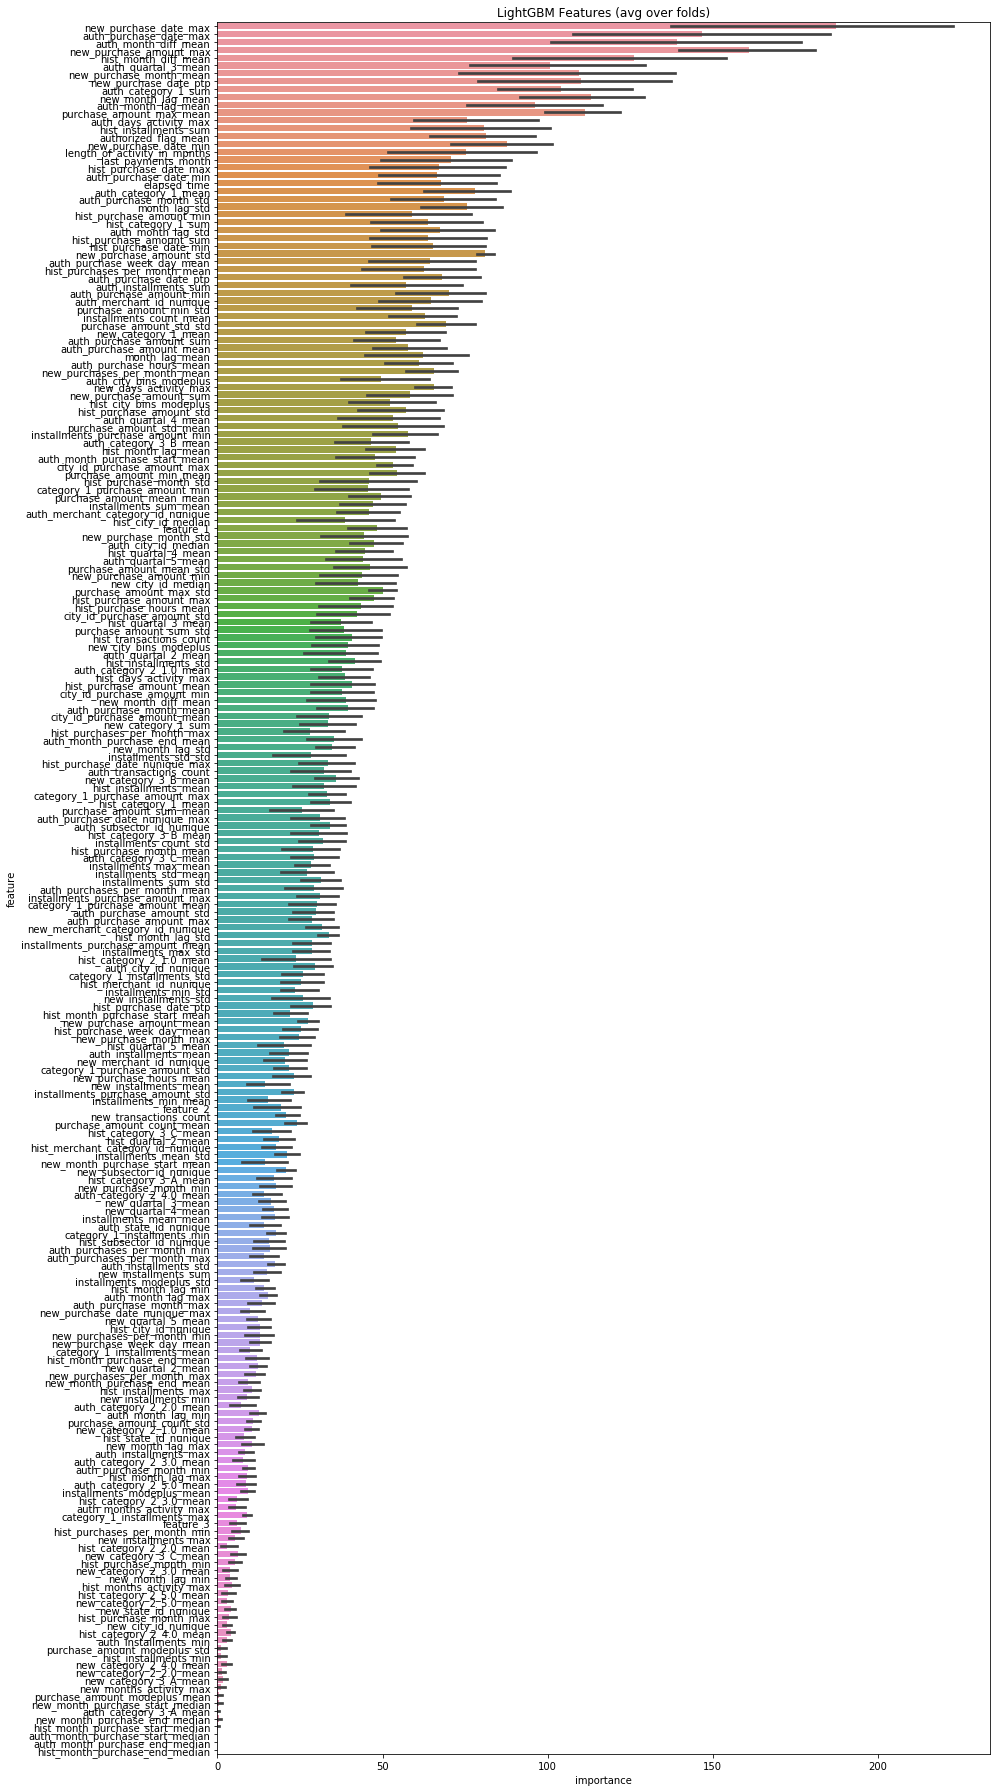

In [168]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [169]:
columns_rating = pd.DataFrame(best_features.groupby(['feature'])['importance'].mean()).sort_values(by='importance')

In [138]:
to_drop = columns_rating[columns_rating.importance < 10].index

In [60]:
#train.drop(to_drop,inplace=True,axis=1)
#test.drop(to_drop,inplace=True,axis=1)

In [81]:
#to_add = columns_rating.sort_values(by='importance',ascending=False)[:30]

In [84]:
train2 = train[list(to_add.index) + ['card_id']]
test2 =test[list(to_add.index) + ['card_id']]

In [170]:
sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submit.csv", index=False)

In [179]:
shop_submit = pd.read_csv("submit.csv")

In [180]:
shop_submit['old_ver_target'] = predictions

In [181]:
shop_submit['diff'] = np.abs(shop_submit.target - shop_submit.old_ver_target)